### Example: Moving-Horizon Simulataneous Input-and-State Estimation

In [1]:
import numpy as np
import cvxpy as cp 
from scipy.linalg import sqrtm, expm
from mh_sise import Data, System, Problem, QConstraints, QRegularization

# define dimmensions
N, n, m, p = 100, 4, 2, 2 # horizon, states, inputs, outpuit
c = 2*m #constraints

#- define variables
x_var = cp.Variable((n, N), name='xvar')
u_var = cp.Variable((m, N), name='uvar')
v_var = cp.Variable((p, N), name='vvar')
w_var = cp.Variable((n, N), name='vvar')

# define parameters
Q_v_sqrt = cp.Parameter((p, p), name='Q_v_sqrt')
Q_w_sqrt = cp.Parameter((n, n), name='Q_w_sqrt')
L = cp.Parameter((m, m), name='L')
y = cp.Parameter((p,N), name='y')
x0 = cp.Parameter(n, name='x0')
u0 = cp.Parameter(n, name='u0')
A = cp.Parameter((n,n), name='A')
B = cp.Parameter((n,m), name='B')
C = cp.Parameter((p,n), name='C')

# define objective
objective = cp.Minimize(
    cp.sum_squares( Q_w_sqrt@w_var[:,:N] ) + cp.sum_squares( Q_v_sqrt@v_var[:,:N] ) + cp.sum_squares( L@u_var[:,:N] )  
)

#dpp (diciplined programming principle) check
print(objective.is_dcp(dpp=True))

# define constraints
constraints = [
    w_var[:,0] == x_var[:,0] - x0,
    w_var[:,1:] == x_var[:,1:N] - A@x_var[:,0:N-1] - B@u_var[:,0:N-1],
    v_var[:,:N] == y[:,:N] - C@x_var[:,:N]
]

# define problem
problem = cp.Problem(objective, constraints)

True


**Define system and simulate**

In [2]:
import numpy as np
from scipy.linalg import expm

def c2d(A, B, ts):
    """
    Converts a continuous-time system (A, B) to a discrete-time system (Ad, Bd) 
    using a sample time ts.
    
    Parameters:
    A (ndarray): Continuous-time state matrix.
    B (ndarray): Continuous-time input matrix.
    ts (float): Sample time.
    
    Returns:
    tuple: Discrete-time state matrix Ad and input matrix Bd.
    """
    n, m = np.shape(B)
    
    # Augment A and B matrices for matrix exponential
    s = np.concatenate([A, B], axis=1)
    s = np.concatenate([s, np.zeros((m, n + m))], axis=0)
    
    # Compute matrix exponential
    S = expm(s * ts)
    
    # Extract discrete-time matrices Ad and Bd
    Ad = S[:n, :n]
    Bd = S[:n, n:n + m]
    
    return Ad, Bd

def lti_sim(A, B, C, x0, ts):
    #initialize y
    y = np.zeros((p, N))  # Output matrix for simulation
    #initial state
    x = np.zeros(n)  # Initial state
    #simulate
    for k in range(N):
        x = A @ x + B @ u[:, k]
        y[:, k] = C @ x
    return y

# Define system parameters
inertia = [1E-2, 1]
damping = [0.01, 0.01]
stiffness = [1000, 1000]
friction = [0.1]

# Define continuous-time system matrices
Ac = np.array([
    [-(friction[0] + damping[0] / inertia[0]), damping[0] / inertia[0], -stiffness[0] / inertia[0], stiffness[0] / inertia[0]],
    [damping[0] / inertia[1], -(damping[0] + damping[1]) / inertia[1], stiffness[0] / inertia[1], -(stiffness[0] + stiffness[1]) / inertia[1]],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

Bc = np.array([
    [1 / inertia[0], 0],
    [0, -1 / inertia[1]],
    [0, 0],
    [0, 0]
])

Cc = np.array([
    [0, 0, stiffness[0], -stiffness[1]],
    [1, 0, 0, 0]
])

# Sampling time
ts = 0.001

# Convert to discrete-time model
Ad, Bd = c2d(Ac, Bc, ts)

# Covariance matrices for noise (assumed zero-mean Gaussian noise)
Q_v = 0.001 * np.eye(p)  # Measurement noise covariance
Q_w = 0.001 * np.eye(n)  # Process noise covariance

# Input signal (u) and initial state (x)
u = np.ones((m, N))
u[1, 20:40] = 5  # Modify second input at step 1
u[1, 60:70] = -5  # Modify second input at step 1
ysim = lti_sim(Ad, Bd, Cc, x0, ts)

**Assign parameters**

In [3]:
# assign cvx parameter values
Q_v_sqrt.value = sqrtm(Q_v)
Q_w_sqrt.value = sqrtm(Q_w)
A.value = Ad
B.value = Bd
C.value = Cc
x0.value = np.zeros(n)
x0.value = np.zeros(n)
L.value = 0*np.eye(m)
y.value = ysim

**Solve problem**

In [4]:
import time

t0 = time.time()
solution = problem.solve()
t1 = time.time()

print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % solution)


CVXPY
Solve time: 27.006 ms
Objective function value: 0.000005



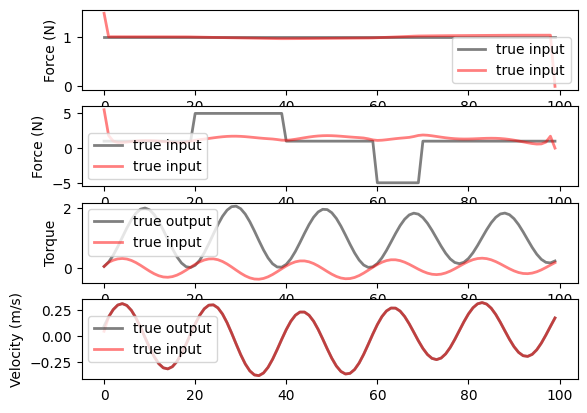

In [5]:
import matplotlib.pyplot as plt

# plot result
fig, axs = plt.subplots(4)
axs[0].plot(u[0,:].T,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].plot(u_var.value[0,:].T,'r', alpha=0.5, linewidth=2, label='true input')
axs[0].set_ylabel('Force (N)')
axs[0].legend()

axs[1].plot(u[1,:].T,'k', alpha=0.5, linewidth=2, label='true input')
axs[1].plot(u_var.value[1,:].T,'r', alpha=0.5, linewidth=2, label='true input')
axs[1].set_ylabel('Force (N)')
axs[1].legend()

axs[2].plot(ysim[0,:].T,'k', alpha=0.5, linewidth=2, label='true output')
axs[2].plot(x_var.value[0,:].T,'r', alpha=0.5, linewidth=2, label='true input')
axs[2].set_ylabel('Torque')
axs[2].legend()

axs[3].plot(ysim[1,:].T,'k', alpha=0.5, linewidth=2, label='true output')
axs[3].plot(x_var.value[0,:].T,'r', alpha=0.5, linewidth=2, label='true input')
axs[3].set_ylabel('Velocity (m/s)')
axs[3].legend()
